### Disaster Tweet Classification ###

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
from collections import Counter
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [137]:
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from sklearn.decomposition import LatentDirichletAllocation

In [139]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

In [140]:
file_path = './Dataset.csv'
Data = pd.read_csv(file_path)

In [141]:
Data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [142]:
Data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [143]:
Data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [144]:
dataset_info = Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5079 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [145]:
dataset_info

In [146]:
Data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [147]:
Data.shape

(7613, 5)

In [148]:
Data['id'].max()

np.int64(10873)

In [149]:
# There are no Duplicate ids in the Dataset
Data['id'].is_unique

True

In [150]:
missing_ids = 10873 - 7613  

In [151]:
# ≈ 3260 IDs are missing/skipped
missing_ids

3260

In [152]:
Data.isna().sum()

id             0
keyword       61
location    2534
text           0
target         0
dtype: int64

In [153]:
# Handle the NUll values by replacing then with 'unknown'
Data['keyword'] = Data['keyword'].fillna('unknown')
Data['location'] = Data['location'].fillna('unknown')

In [154]:
Data.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [155]:
# Check the distribution of the 'target' column (disaster vs. non-disaster tweets)
class_distribution = Data['target'].value_counts()

In [156]:
class_distribution

target
0    4342
1    3271
Name: count, dtype: int64

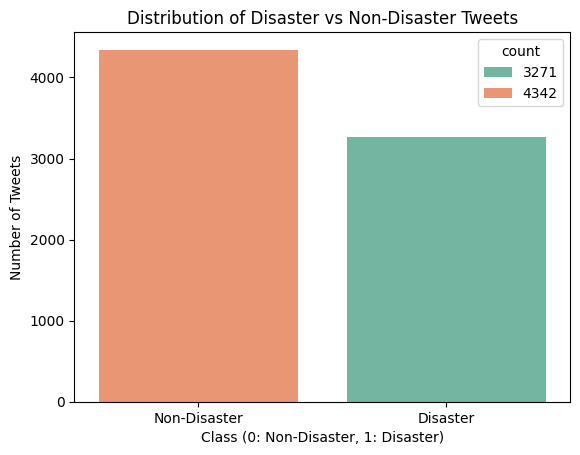

In [157]:
# Plot the distribution
plt.Figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='Set2' ,hue =class_distribution)
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xlabel('Class (0: Non-Disaster, 1: Disaster)')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=[0, 1], labels=['Non-Disaster', 'Disaster'])
plt.show()

Analyze the frequency of keywords and phrases associated with disaster
tweets.

In [158]:
# 2. Word Frequency Analysis
# Separate disaster and non-disaster tweets
disaster_tweets = Data[Data['target'] == 1]['text']
non_disaster_tweets = Data[Data['target'] == 0]['text']

In [159]:
disaster_tweets,non_disaster_tweets

(0       Our Deeds are the Reason of this #earthquake M...
 1                  Forest fire near La Ronge Sask. Canada
 2       All residents asked to 'shelter in place' are ...
 3       13,000 people receive #wildfires evacuation or...
 4       Just got sent this photo from Ruby #Alaska as ...
                               ...                        
 7608    Two giant cranes holding a bridge collapse int...
 7609    @aria_ahrary @TheTawniest The out of control w...
 7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
 7611    Police investigating after an e-bike collided ...
 7612    The Latest: More Homes Razed by Northern Calif...
 Name: text, Length: 3271, dtype: object,
 15                                         What's up man?
 16                                          I love fruits
 17                                       Summer is lovely
 18                                      My car is so fast
 19                           What a goooooooaaaaaal!!!!!!
              

In [160]:
# Use CountVectorizer to get the frequency of words in disaster tweets
disaster_vectorizer = CountVectorizer(stop_words='english', max_features=20)
temp_dd = disaster_vectorizer.fit_transform(disaster_tweets)

In [161]:
# Get the most frequent words
disaster_word_frequencies = temp_dd.sum(axis=0).A1
disaster_words = disaster_vectorizer.get_feature_names_out()

In [162]:
disaster_words

array(['amp', 'bomb', 'california', 'crash', 'disaster', 'families',
       'fires', 'hiroshima', 'http', 'https', 'just', 'killed', 'like',
       'news', 'people', 'police', 'storm', 'suicide', 'train', 'û_'],
      dtype=object)

In [163]:
# Create a DataFrame of words and their frequencies
word_freq_df = pd.DataFrame({'Word': disaster_words, 'Frequency': disaster_word_frequencies})
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

In [164]:
word_freq_df

,Word,Frequency
8,http,2263
19,û_,164
0,amp,130
13,news,127
4,disaster,118
9,https,116
2,california,114
17,suicide,111
15,police,107
14,people,103


### Data Preparation ###

Clean the text data by removing special characters, URLs, and punctuation marks.

In [165]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+https\S+','',text)
    text = re.sub(r'[^a-zA-Z\s]','',text)
    text = text.lower()
    return text

In [166]:
# Apply the text cleaning
Data['cleaned_text'] = Data['text'].apply(clean_text)

In [167]:
Data['cleaned_text']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610                        m  utckm s of volcano hawaii 
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: cleaned_text, Length: 7613, dtype: object

Tokenize the text into individual words or tokens.

In [168]:
Data['tokens'] = Data['cleaned_text'].apply(lambda x: x.split())

In [169]:
Data['tokens'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: tokens, dtype: object

In [170]:
# Save the preprocessed DataFrame as a CSV file
Data.to_csv('preprocessed_dataset.csv', index=False)

print("Dataset saved as CSV successfully!")

Dataset saved as CSV successfully!


-------------------------------------

Split the dataset into training and testing sets for model development and
evaluation.

- Since the task is to classify tweets as either disaster-related or not based on their content, the most relevant feature is the text itself. The 'text' contains the information (words, phrases) that the model will analyze to make predictions.
- The other columns (like 'id', 'keyword', 'location') are less likely to help in determining whether a tweet is related to a disaster. In fact, including irrelevant columns could lead to noise and potentially hurt the model's performance.

In [171]:
# Split the data into feature(x) and target(y)
x= Data['cleaned_text'] # Features: cleaned_text
y= Data['target'] #Target:0 for non-disaster , 1 for Disaster

In [172]:
# Split the Data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 42)

In [173]:
# Show the first few rows of the cleaned data
Data[['text', 'cleaned_text', 'tokens', 'target']].head()

,text,cleaned_text,tokens,target
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...",1
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",1
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...",1
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...",1
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...",1


***Exploratory Data Analysis(EDA)***

In [174]:
## Distribution of Tweet lengths

# Add a column for tweet length(number of words)
Data['tweet_length'] = Data['tokens'].apply(len)

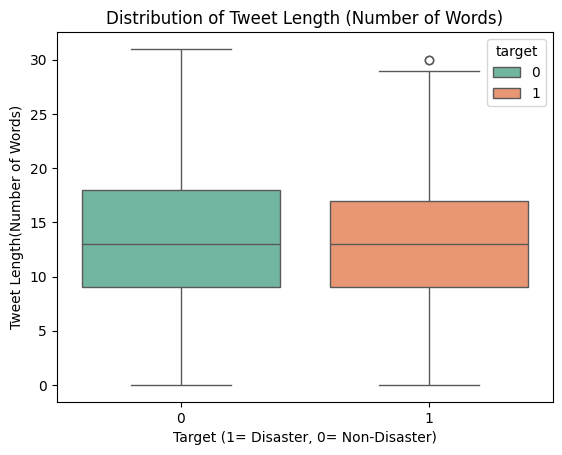

In [175]:
# Plot the distribution of tweet length for both disaster and non-disaster tweet
plt.Figure(figsize=(8,6))
sns.boxplot(x='target', y='tweet_length', data=Data, palette='Set2', hue='target')
plt.title('Distribution of Tweet Length (Number of Words)')
plt.xlabel('Target (1= Disaster, 0= Non-Disaster)')
plt.ylabel('Tweet Length(Number of Words)')
plt.xticks([0,1]),['Non-Disaster', 'Disaster']
plt.show() 

We can observe if there's a significant difference in tweet lengths between the two classes.

---------------------------

- analyzing the most frequent keywords in disaster-related and non-disaster-related tweets.
-  This will help us understand the language or terms associated with each class.

In [176]:
# Separate disaster and non-disaster tweets
disaster_tweets = Data[Data['target'] == 1]['cleaned_text']
non_disaster_tweets = Data[Data['target'] == 0]['cleaned_text']

In [177]:
# Use CountVectorizer to get the frequency of word in both disaster and non-disaster tweets
# Function to get the top words
def get_top_words(tweets, n=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=n)
    temp = vectorizer.fit_transform(tweets)
    word_frequencies = temp.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    words_df = pd.DataFrame({'Words': words, 'Frequency' : word_frequencies}).sort_values(by='Frequency', ascending=False)
    return words_df

In [178]:
# Get the top 10 words for Disaster amd Non-Disaster tweets
top_disaster_words = get_top_words(disaster_tweets, n=10)
top_non_disaster_words = get_top_words(non_disaster_tweets, n=10)

In [179]:
top_disaster_words, top_non_disaster_words

(        Words  Frequency
 6        news        127
 2    disaster        114
 1  california        110
 9     suicide        109
 8      police        105
 7      people        103
 0         amp        102
 4      killed         92
 5        like         89
 3   hiroshima         89,
     Words  Frequency
 5    like        244
 3      im        243
 4    just        228
 0     amp        190
 7     new        170
 2    dont        151
 1    body        113
 9   video         94
 8  people         90
 6    love         86)

***Part 2: Feature Engineering and Model Selection***

extract several types of features from the text data to help improve the performance of the model

***Word Frequency (Bag of Words)***

Extract word frequencies using the CountVectorizer or TF-IDF (Term Frequency-Inverse Document Frequency) to capture the importance of words in the context of the dataset.

In [180]:
# Extract Word Frequencies using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1006)
x_tfidf = tfidf_vectorizer.fit_transform(Data['cleaned_text']).toarray()

In [181]:
import joblib

# Save the TF-IDF vectorizer for future use
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_lr.pkl')
print("TF-IDF vectorizer saved successfully.")

TF-IDF vectorizer saved successfully.


In [182]:
tfidf_vectorizer

TfidfVectorizer(max_features=1006, stop_words='english')

In [183]:
x_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.40720537, 0.        , ..., 0.        , 0.        ,
        0.        ]])

***Sentiment Analysis***

In [184]:
# 2. Sentiment Analysis using TextBlob
def get_sentiment(text):
    #Polarity score:-1 (negative) to 1(positive)
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

the polarity score helps to assess the emotional tone of the tweet. For example, disaster-related tweets might have a negative polarity because they often discuss tragic events, while non-disaster tweets could be more neutral or positive.

In [185]:
Data['sentiment'] = Data['cleaned_text'].apply(get_sentiment)

In [186]:
Data['sentiment']

0       0.000000
1       0.100000
2      -0.018750
3       0.000000
4       0.000000
          ...   
7608    0.000000
7609    0.150000
7610    0.000000
7611   -0.260417
7612    0.500000
Name: sentiment, Length: 7613, dtype: float64

In [187]:
Data.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'cleaned_text', 'tokens',
       'tweet_length', 'sentiment'],
      dtype='object')

In [188]:
Data['tokens']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [ariaahrary, thetawniest, the, out, of, contro...
7610                   [m, utckm, s, of, volcano, hawaii]
7611    [police, investigating, after, an, ebike, coll...
7612    [the, latest, more, homes, razed, by, northern...
Name: tokens, Length: 7613, dtype: object

In [189]:
# Extract Tweet Length (Number of words)
Data['tweet_length'] = Data['tokens'].apply(len)

In [190]:
Data['tweet_length']

0       13
1        7
2       22
3        7
4       16
        ..
7608    10
7609    20
7610     6
7611    19
7612    11
Name: tweet_length, Length: 7613, dtype: int64

In [191]:
# Count the number of hashtags in the tweet
Data['hashtag_count'] = Data['text'].apply(lambda x:x.count('#'))

In [192]:
Data['hashtag_count']

0       1
1       0
2       0
3       1
4       2
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: hashtag_count, Length: 7613, dtype: int64

In [193]:
Data['hashtag_count'].max()

np.int64(13)

In [194]:
# Count the number of user mentions in the tweet
Data['mention_user_count'] = Data['text'].apply(lambda x: x.count('@'))

In [195]:
Data['mention_user_count'].sum

<bound method Series.sum of 0       0
1       0
2       0
3       0
4       0
       ..
7608    0
7609    2
7610    0
7611    0
7612    0
Name: mention_user_count, Length: 7613, dtype: int64>

***Summary***

- TF-IDF features capture the meaning and importance of words in the tweet.
- Additional features provide context about the tweet's length, sentiment, and structure.
- Combining them creates a comprehensive feature set that improves the model's ability to make informed predictions.

In [196]:
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Bigrams
X_ngrams = vectorizer.fit_transform(Data['cleaned_text']).toarray()

In [197]:
X_ngrams

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [198]:
# Combine the TF_IDF features with additional features
x_features = np.hstack([x_tfidf, Data[['sentiment', 'tweet_length', 'hashtag_count', 'mention_user_count']].values])

In [199]:
# Show the first few rows of the feature matrix
#Data[['sentiment', 'tweet_length', 'hashtag_count','mention_user_count','entities']].head()

----------------------------------------------

***Topic Modeling (LDA)***
LDA to discover whether disaster-related tweets tend to belong to certain topics (e.g., emergency response, weather reports).

In [200]:
# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda_features = lda.fit_transform(x_tfidf)

In [201]:
lda_features

array([[0.13834135, 0.415079  , 0.44657965],
       [0.12439102, 0.35198674, 0.52362225],
       [0.1270364 , 0.43395329, 0.43901032],
       ...,
       [0.65045438, 0.18276511, 0.16678052],
       [0.8011575 , 0.10175459, 0.09708791],
       [0.08824068, 0.82362397, 0.08813535]])

In [202]:
# Step 3: Get the top words for each topic
terms = tfidf_vectorizer.get_feature_names_out()

In [203]:
terms

array(['aba', 'abc', 'ablaze', ..., 'youve', 'yr', 'zone'], dtype=object)

In [204]:
# Function to display the top words for each topic
def print_top_words(model, feature_names, n_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
        print()

In [205]:
# Display the top 10 words for each topic
print_top_words(lda, terms)

Topic 0:
dont people nuclear just bomb suicide car amp hiroshima did

Topic 1:
disaster burning like video buildings im just youtube collapse police

Topic 2:
im storm emergency new body like life death watch mass



Topic 1:

    Top Words: "emergency", "news", "body", "youtube", "california", "attack", "time", "video", "new", "wildfire".

    Explanation: This topic appears to be associated with news coverage of emergency events. Words like "emergency", "news", "wildfire", and "attack" suggest that this topic is likely about disaster-related news stories (possibly including fires and emergency response). The presence of "youtube" and "video" indicates that these might be social media or video-sharing discussions about the events.

Topic 2:

    Top Words: "burning", "buildings", "accident", "pm", "man", "police", "lol", "like", "years", "flames".

    Explanation: This topic seems to reflect disaster-related events (e.g., "burning", "buildings", "flames") and possibly accidents (e.g., "accident"). Words like "police" and "man" suggest there might be references to emergency responders or public safety during an incident. The inclusion of "lol" might indicate sarcasm or irony, possibly in tweets discussing accidents or situations that people find unbelievable.

How to Interpret:

    Each topic is a mixture of words that often appear together in tweets. The goal of LDA is to uncover these latent topics that represent underlying themes in a large corpus of text.

    The top words are the ones that are most strongly associated with each topic, and their interpretation provides an idea of the context of each topic. For example, the words "wildfire", "news", and "attack" in Topic 1 likely point to news articles or reports about specific disasters.

In [206]:
# Step 1: Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # 3 topics
lda_features = lda.fit_transform(x_tfidf)

In [207]:
# Step 2: Get the topic with the highest probability for each tweet (most likely topic)
topics = lda_features.argmax(axis=1)

In [208]:
# Step 3: Add the most likely topic to the dataset
Data['assigned_topic'] = topics

In [209]:
# Display the first few rows of the dataset with assigned topics
Data[['text', 'assigned_topic']].head()

,text,assigned_topic
0,Our Deeds are the Reason of this #earthquake M...,2
1,Forest fire near La Ronge Sask. Canada,2
2,All residents asked to 'shelter in place' are ...,2
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,2


In [210]:
# Count the number of tweets assigned to each topic
topic_counts = Data['assigned_topic'].value_counts()

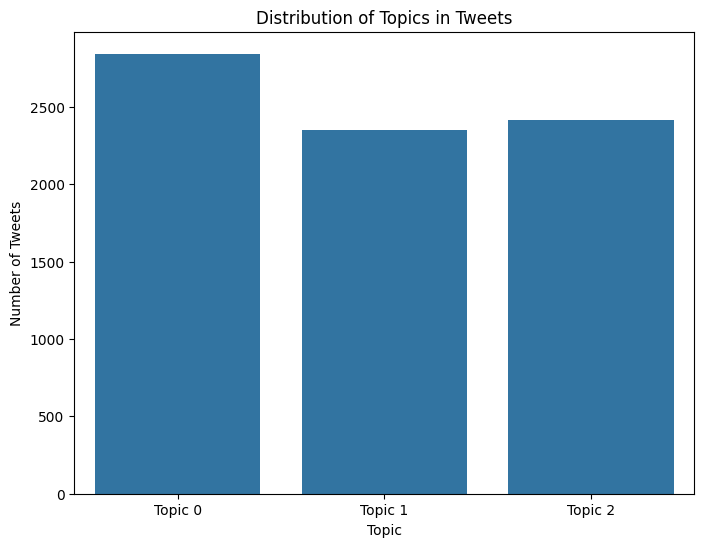

In [211]:
# Plot the distribution of assigned topics
plt.figure(figsize=(8, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.title('Distribution of Topics in Tweets')
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.xticks(topic_counts.index, [f'Topic {i}' for i in topic_counts.index])
plt.show()

***Named Entity Recognition (NER)***

NER identifies proper nouns such as names of places, people, organizations, or specific events. Disaster-related tweets may contain references to places (e.g., "California", "Tokyo") or organizations (e.g., "Red Cross").

In [212]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [213]:
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

In [214]:
Data['entities'] = Data['cleaned_text'].apply(extract_entities)

In [215]:
Data['entities']

0                           []
1                 [la, canada]
2                           []
3                 [california]
4                     [alaska]
                 ...          
7608                     [two]
7609              [california]
7610                        []
7611                [portugal]
7612    [california, abc news]
Name: entities, Length: 7613, dtype: object

In [216]:
# Flatten the list of entities and count their occurrences
all_entities = [entity for sublist in Data['entities'] for entity in sublist]
entity_counts = Counter(all_entities)

In [217]:
# Get the 10 most common entities
top_entities = entity_counts.most_common(10)

In [218]:
top_entities

[('california', 104),
 ('first', 97),
 ('hiroshima', 87),
 ('one', 85),
 ('two', 82),
 ('today', 79),
 ('japan', 42),
 ('tonight', 38),
 ('iran', 35),
 ('hundreds', 33)]

In [219]:
# Define a list of common non-entity words to filter out
common_non_entities = {'first', 'one', 'two', 'three', 'four', 'five', 'hundreds', 'today', 'tonight', 'august', 'tomorrow' }

In [220]:
# Function to filter out common non-entity words
def filter_entities(entities):
    return [entity for entity in entities if entity.lower() not in common_non_entities]

In [221]:
#Apply the filter to the extracted entities
Data['filtered_entities'] = Data['entities'].apply(filter_entities)

In [222]:
Data['filtered_entities']

0                           []
1                 [la, canada]
2                           []
3                 [california]
4                     [alaska]
                 ...          
7608                        []
7609              [california]
7610                        []
7611                [portugal]
7612    [california, abc news]
Name: filtered_entities, Length: 7613, dtype: object

In [223]:
# Flatten the filtered entities list and count their occurrences
all_filtered_entities = [entity for sublist in Data['filtered_entities'] for entity in sublist]
filtered_entity_counts = Counter(all_filtered_entities)

In [224]:
filtered_entity_counts

Counter({'california': 104,
         'hiroshima': 87,
         'japan': 42,
         'iran': 35,
         'us': 30,
         'israeli': 28,
         'calgary': 28,
         'saudi': 27,
         'mh malaysia': 25,
         'american': 24,
         'under a minute': 24,
         'years': 23,
         'malaysia': 23,
         'second': 21,
         'india': 21,
         'russian': 20,
         'bush': 20,
         'summer': 19,
         'christian': 19,
         'muslims': 18,
         'islam': 18,
         'thousands': 17,
         'gop': 17,
         'china': 17,
         'myanmar': 16,
         'london': 16,
         'daily': 16,
         'pakistani': 16,
         'russia': 16,
         'texas': 16,
         'half': 16,
         'pakistan': 16,
         'utc': 16,
         'america': 15,
         'israel': 15,
         'the day': 15,
         'pamela geller   ': 15,
         'thursday': 15,
         'nagasaki': 15,
         'france': 14,
         'wednesday': 14,
         'twelve': 14

In [225]:
top_filtered_entities = filtered_entity_counts.most_common(10)

In [226]:
top_filtered_entities

[('california', 104),
 ('hiroshima', 87),
 ('japan', 42),
 ('iran', 35),
 ('us', 30),
 ('israeli', 28),
 ('calgary', 28),
 ('saudi', 27),
 ('mh malaysia', 25),
 ('american', 24)]

In [227]:
# Prepare data for visualization
filtered_entities, filtered_counts = zip(*top_filtered_entities)

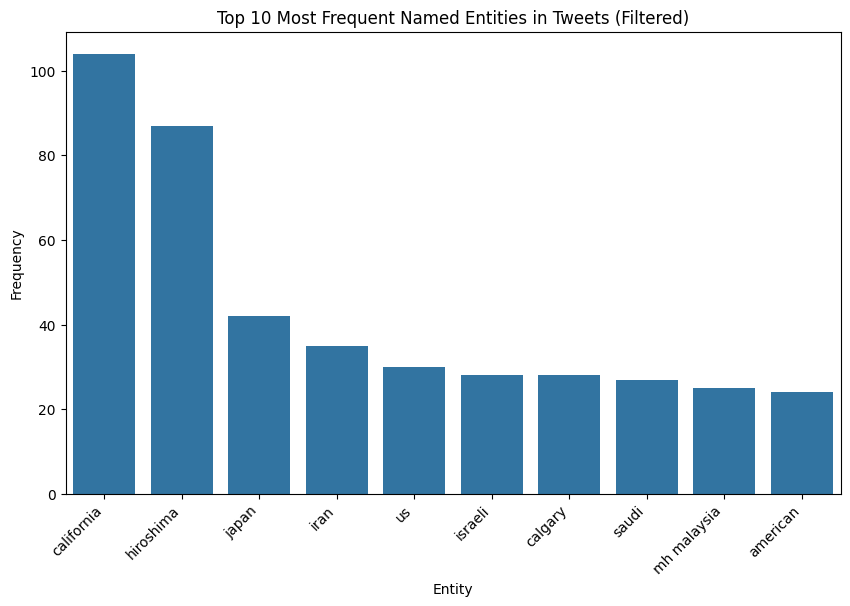

In [228]:
# Plot the most frequent named entities after filtering out common terms
plt.figure(figsize=(10, 6))
sns.barplot(x=list(filtered_entities), y=list(filtered_counts))
plt.title('Top 10 Most Frequent Named Entities in Tweets (Filtered)')
plt.xlabel('Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

----------------------------------------------------------------------------

***Task: Model Selection and Training***

In [229]:
Data.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'cleaned_text', 'tokens',
       'tweet_length', 'sentiment', 'hashtag_count', 'mention_user_count',
       'assigned_topic', 'entities', 'filtered_entities'],
      dtype='object')

In [230]:
Data = Data.drop(columns='entities')

In [231]:
Data.head()

,id,keyword,location,text,target,cleaned_text,tokens,tweet_length,sentiment,hashtag_count,mention_user_count,assigned_topic,filtered_entities
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...",13,0.00000,1,0,2,[]
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",7,0.10000,0,0,2,"[la, canada]"
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...",22,-0.01875,0,0,2,[]
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...",7,0.00000,1,0,1,[california]
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...",16,0.00000,2,0,2,[alaska]


In [232]:
Data.dtypes

id                      int64
keyword                object
location               object
text                   object
target                  int64
cleaned_text           object
tokens                 object
tweet_length            int64
sentiment             float64
hashtag_count           int64
mention_user_count      int64
assigned_topic          int64
filtered_entities      object
dtype: object

In [233]:
Data.isna().sum()

id                    0
keyword               0
location              0
text                  0
target                0
cleaned_text          0
tokens                0
tweet_length          0
sentiment             0
hashtag_count         0
mention_user_count    0
assigned_topic        0
filtered_entities     0
dtype: int64

In [234]:
Data.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'cleaned_text', 'tokens',
       'tweet_length', 'sentiment', 'hashtag_count', 'mention_user_count',
       'assigned_topic', 'filtered_entities'],
      dtype='object')

***Columns to Include for Modeling***

'cleaned_text': This will be used for TF-IDF vectorization to capture the semantic content of the tweet.

'sentiment': The sentiment score can help understand the tone of the tweet.

'tweet_length': Length of the tweet, which could be relevant for classification.

'hashtag_count': Number of hashtags in the tweet, which can be important for disaster-related topics.

'mention_user_count': The number of user mentions in the tweet.

'assigned_topic': Topic assigned to each tweet based on the LDA model.

***Target Column***

'target': This is the label (1 for disaster, 0 for non-disaster).

In [235]:
def identify_columns(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_columns = df.select_dtypes(include=['number']).columns.tolist()
    
    return categorical_columns, continuous_columns

In [236]:
categorical_columns, continuous_columns = identify_columns(Data)

In [237]:
print(f"categorical_columns : {categorical_columns} \ncontinuous_columns : {continuous_columns}")

categorical_columns : ['keyword', 'location', 'text', 'cleaned_text', 'tokens', 'filtered_entities'] 
continuous_columns : ['id', 'target', 'tweet_length', 'sentiment', 'hashtag_count', 'mention_user_count', 'assigned_topic']


In [238]:
categorical_columns

['keyword', 'location', 'text', 'cleaned_text', 'tokens', 'filtered_entities']

In [239]:
for col in categorical_columns:
    print(col)

keyword
location
text
cleaned_text
tokens
filtered_entities


In [240]:
Data['tokens']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [ariaahrary, thetawniest, the, out, of, contro...
7610                   [m, utckm, s, of, volcano, hawaii]
7611    [police, investigating, after, an, ebike, coll...
7612    [the, latest, more, homes, razed, by, northern...
Name: tokens, Length: 7613, dtype: object

In [241]:
categorical_columns_new = ['keyword', 'location']
continuous_columns_new = ['tweet_length', 'sentiment', 'mention_user_count', 'assigned_topic']

In [242]:
# Encode Categorical features 'keyword' and 'location'
label_encoder = LabelEncoder()
for col in categorical_columns_new:
    Data[f'{col}_encoded'] = label_encoder.fit_transform(Data[col])

In [243]:
Data['location_encoded'].unique()

array([3203,  423,  883, ...,   17, 2642, 1437])

In [244]:
# Include the encoded columns in the feature matrix
#x_features_encoded = np.hstack([temp_tfidf,Data[['sentiment', 'tweet_length', 'hashtag_count', 'mention_user_count', 'keyword_encoded', 'location_encoded' ]]])

In [245]:
#scale the continuos columns
scaler = StandardScaler()
scaled_continuous_features = scaler.fit_transform(Data[continuous_columns_new])

In [246]:
categorical_columns_new

['keyword', 'location']

In [247]:
# Combine the TF-IDF features with the scaled and the encoded categorical columns
x_features_scaled = np.hstack([x_tfidf,scaled_continuous_features,
                                                Data[[f'{col}_encoded' for col in categorical_columns_new]].values])

In [248]:
x_features_scaled

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.27389916e+00,  2.06000000e+02,  3.20300000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.27389916e+00,  2.06000000e+02,  3.20300000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.27389916e+00,  2.06000000e+02,  3.20300000e+03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.13798702e+00,  2.06000000e+02,  3.20300000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.13798702e+00,  2.06000000e+02,  3.20300000e+03],
       [ 0.00000000e+00,  4.07205370e-01,  0.00000000e+00, ...,
         6.79560732e-02,  2.06000000e+02,  3.20300000e+03]])

In [249]:
# Define the target variable(target is disaster or non-disaster)
y = Data['target']

In [250]:
Data.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'cleaned_text', 'tokens',
       'tweet_length', 'sentiment', 'hashtag_count', 'mention_user_count',
       'assigned_topic', 'filtered_entities', 'keyword_encoded',
       'location_encoded'],
      dtype='object')

In [251]:
x = Data[['keyword', 'location' ,'cleaned_text', 'tokens', 'tweet_length']]
y = Data['target']

In [252]:
# Split the Dataset to train and test data sets(80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [253]:
x_train_vec = tfidf_vectorizer.fit_transform(x_train['cleaned_text'])
x_test_vec = tfidf_vectorizer.fit_transform(x_test['cleaned_text'])

In [254]:
x_train_vec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 25331 stored elements and shape (6090, 1006)>

In [255]:
y_train

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64

In [256]:
# Display the first few rows of the processed data
# x_features_scaled[:5], y.head()

In [257]:
x_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.40720537, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [258]:
models = {
    'Logistic Regressor': LogisticRegression(max_iter=5000, random_state=42),  # Increase max_iter
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Neural Network': MLPClassifier(random_state=42),
    'Naive Bayes': MultinomialNB()
}

In [259]:
# Store evaluation metrics for each model
model_metrics = {}

In [260]:
y_train

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64

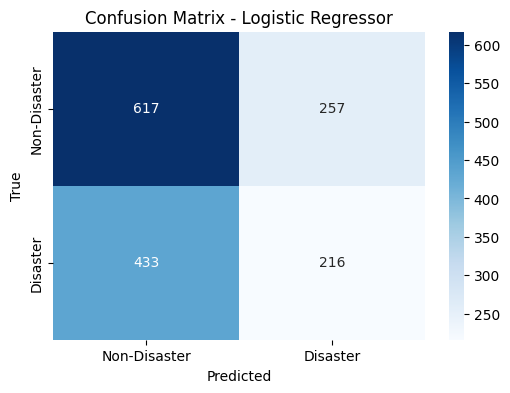

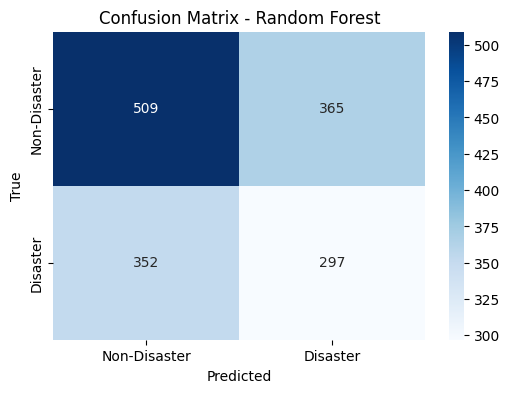

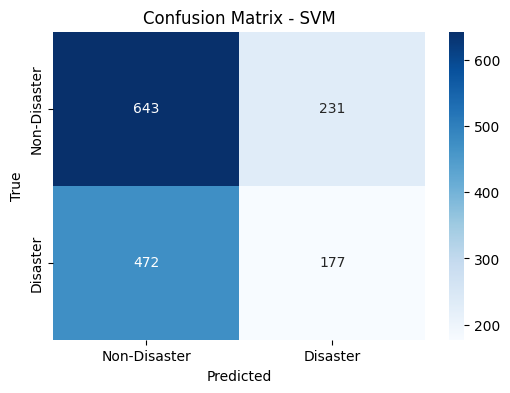

s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

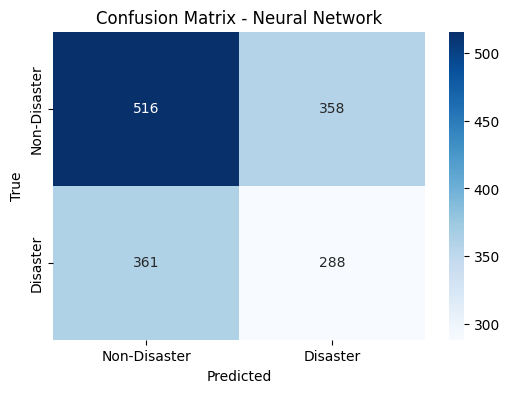

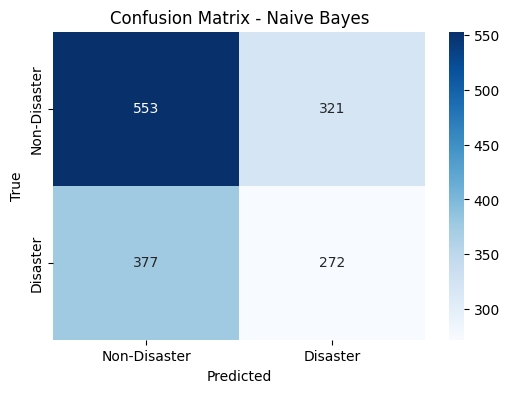

{'Logistic Regressor': np.float64(0.7825944170771757),
 'Random Forest': np.float64(0.7707717569786535),
 'SVM': np.float64(0.7868637110016421),
 'Neural Network': np.float64(0.7474548440065683),
 'Naive Bayes': np.float64(0.7811165845648605)}

In [261]:
cv_scores = {}
for model_name, model in models.items():
    model.fit(x_train_vec, y_train)  # Train the model
    cv_score = cross_val_score(model, x_train_vec, y_train, cv=5, scoring='accuracy')  # Cross-validation score
    cv_scores[model_name] = cv_score.mean()  # Store mean score for each model
    
    # Predictions on the test set
    y_pred = model.predict(x_test_vec)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store the metrics
    model_metrics[model_name] = {
        'accuracy': accuracy,
        'r2_score': r2,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_accuracy': cv_score.mean()  # Cross-validation accuracy
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Displaying the performance of each model
cv_scores

In [262]:
# Displaying the performance of each model
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"R² Score: {metrics['r2_score']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1_score']}")
    print(f"Cross-validation Accuracy: {metrics['cv_accuracy']}")
    print("\n")

Model: Logistic Regressor
Accuracy: 0.5469468154957321
R² Score: -0.8526477982320977
Precision: 0.45665961945031713
Recall: 0.33281972265023113
F1 Score: 0.3850267379679144
Cross-validation Accuracy: 0.7825944170771757


Model: Random Forest
Accuracy: 0.5292186474064347
R² Score: -0.9251427120759625
Precision: 0.4486404833836858
Recall: 0.4576271186440678
F1 Score: 0.45308924485125857
Cross-validation Accuracy: 0.7707717569786535


Model: SVM
Accuracy: 0.5384110308601444
R² Score: -0.8875527567495141
Precision: 0.4338235294117647
Recall: 0.2727272727272727
F1 Score: 0.33491012298959316
Cross-validation Accuracy: 0.7868637110016421


Model: Neural Network
Accuracy: 0.5279054497701904
R² Score: -0.9305127056940266
Precision: 0.4458204334365325
Recall: 0.4437596302003082
F1 Score: 0.44478764478764476
Cross-validation Accuracy: 0.7474548440065683


Model: Naive Bayes
Accuracy: 0.5416940249507551
R² Score: -0.8741277727043539
Precision: 0.45868465430016864
Recall: 0.41910631741140214
F1 Sco

-------------------------------------------------

In [263]:
from sklearn.model_selection import cross_val_score

# Store evaluation metrics for each model
model_metrics = {}

# Train and evaluate each model using cross-validation
for model_name, model in models.items():
    model.fit(x_train_vec, y_train)  # Train the model

    # Cross-validation to get accuracy scores
    cv_score = cross_val_score(model, x_train_vec, y_train, cv=5, scoring='accuracy')  # Cross-validation score

    # Calculate evaluation metrics
    accuracy = cv_score.mean()

    model_metrics[model_name] = {
        'accuracy': accuracy,
    }

# Displaying the performance of each model
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    print(f"Cross-validation Accuracy: {metrics['accuracy']}")
    print("\n")


s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Model: Logistic Regressor
Cross-validation Accuracy: 0.7825944170771757


Model: Random Forest
Cross-validation Accuracy: 0.7707717569786535


Model: SVM
Cross-validation Accuracy: 0.7868637110016421


Model: Neural Network
Cross-validation Accuracy: 0.7474548440065683


Model: Naive Bayes
Cross-validation Accuracy: 0.7811165845648605




s:\Data Science by DigiCrome\Internship\Project_7\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


-------------------------------------------------

In [264]:
# Hyperparameter for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'] }

In [265]:
# Hyperparameter for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [266]:
# Hyperparameter tuning for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=7000), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(x_train_vec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=7000),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [267]:
# Hyperparameter tuning for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(x_train_vec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [268]:
# Display best parameters for each model
print(f"Best Parameters for Logistic Regression: {grid_search_lr.best_params_}")
print(f"Best Accuracy for Logistic Regression: {grid_search_lr.best_score_}")

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best Accuracy for Random Forest: {grid_search_rf.best_score_}")

Best Parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best Accuracy for Logistic Regression: 0.7832512315270936
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy for Random Forest: 0.771264367816092


In [269]:
import joblib

# Save the best Logistic Regression model (after training)
joblib.dump(grid_search_lr.best_estimator_, 'logistic_regression_model.pkl')

print("Logistic Regression model has been saved successfully!")

Logistic Regression model has been saved successfully!


Load the Saved Model Later:

In [270]:
# Load the saved Logistic Regression model
loaded_lr_model = joblib.load('logistic_regression_model.pkl')

In [271]:
# Example: Make predictions with the loaded model
y_pred_loaded = loaded_lr_model.predict(x_test_scaled)

NameError: name 'x_test_scaled' is not defined

In [ ]:
y_pred_loaded

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
# Evaluate the accuracy of the loaded model
loaded_model_accuracy = accuracy_score(y_test, y_pred_loaded)

In [ ]:
print(f"Accuracy of loaded Logistic Regression model: {loaded_model_accuracy:.4f}")

Accuracy of loaded Logistic Regression model: 0.7649


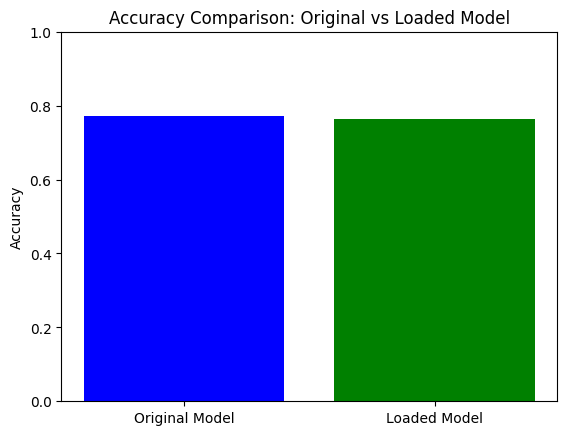

In [ ]:
# Assuming you have accuracy values from the original model and loaded model
original_accuracy = accuracy_score(y_test, y_pred)  # accuracy from the original model
loaded_model_accuracy = accuracy_score(y_test, y_pred_loaded)  # accuracy from the loaded model

# Create a bar chart to compare the accuracy
labels = ['Original Model', 'Loaded Model']
accuracy_values = [original_accuracy, loaded_model_accuracy]

plt.bar(labels, accuracy_values, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Original vs Loaded Model')
plt.ylim([0, 1])  # Set y-axis from 0 to 1 for accuracy
plt.show()

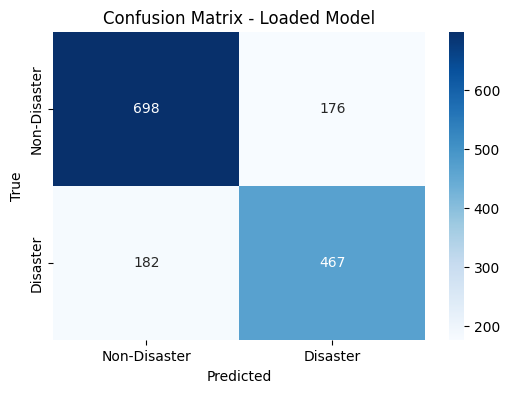

In [ ]:

# Get confusion matrix for the loaded model
cm_loaded_model = confusion_matrix(y_test, y_pred_loaded)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_loaded_model, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.title('Confusion Matrix - Loaded Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob_loaded_model = loaded_model.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_loaded_model)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Loaded Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'loaded_model' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming you already have these values
original_accuracy = accuracy_score(y_test, y_pred)  # accuracy from the original model
loaded_model_accuracy = accuracy_score(y_test, y_pred_loaded)  # accuracy from the loaded model

# Create a bar chart to compare the accuracy
labels = ['Original Model', 'Loaded Model']
accuracy_values = [original_accuracy, loaded_model_accuracy]

plt.bar(labels, accuracy_values, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Original vs Loaded Model')
plt.ylim([0, 1])  # Set y-axis from 0 to 1 for accuracy
plt.show()

-------------------------------------------